In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sl

import seaborn as sns; sns.set()
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline

In [ ]:
def RK4(X0, t0, dt, func): # actualiza un pasito
    k1 = dt * func(X0, t0)
    k2 = dt * func(X0+k1/2, t0+dt/2)
    k3 = dt * func(X0+k2/2, t0+dt/2)
    k4 = dt * func(X0+k3, t0 + dt)
    return X0 + (k1+2*k2+2*k3+k4)/6

In [ ]:
# Oscilador armonico forzado
# d^2x/dt^2 = -omega^2*x+F(t)
# X = (x, v)
# dX/dt = (v, -omega^2*x+F(t)) === F(X, t)
# Solo necesito las condiciones iniciales....
# de X = (x0, v0)
omega2 = 1
f = lambda t: 2 * np.cos(3*t-2)
def F(X, t): # la derivada de X con respecto a t
    global omega2
    global f
    # X = (x, v)
    return np.array([X[1], -omega2*X[0]+f(t)])

dt = 0.0001
t = np.arange(0,30.,dt)
y0 = np.array([0,0]) # limitacion <-
y_temp = y0
y = []
for idx,_t in enumerate(t):
    if idx == 0:
        y.append(y_temp.copy())
    else:
        # y_temp = y_n-1
        y_temp = RK4(y_temp, _t, dt, F)
        # y_temp = y_n
        y.append(y_temp.copy())
y = np.array(y)

In [ ]:
x = y[:,0] # posiciones
v = y[:,1] # velocidades

In [ ]:
plt.plot(t, x)

# Verlet implementation

In [ ]:
def verlet(X0, X1, t1, dt, func):
    # X1 es el punto anterior y t1 el tiempo
    # X0 es entonces el punto anterior a X1, t0 = t1-dt
    # func es la segunda derivada de X con respecto a t
    X2 = 2*X1-X0+func(X1, t1)*dt*dt
    return X2
def verlet_primer_punto(X0, dt, V0):
    X1 = X0 + V0*dt
    return X1

In [ ]:
# Oscilador armonico forzado
# d^2x/dt^2 = -omega^2*x+F(t)
omega2 = 1
f = lambda t: 2 * np.cos(3*t-2)
def F(X, t): # la derivada de X con respecto a t
    global omega2
    global f
    # X = (x, v)
    return -omega2*X+f(t)

In [ ]:
dt = 0.0001
t = np.arange(0,30.,dt)
y0 = np.array([0,0]) # limitacion <-

y_temp0 = y0[0]
vy0 = y0[1]
y_temp1 = None
y_verlet = []
for idx,_t in enumerate(t):
    if idx == 0:
        y_verlet.append(y_temp.copy())
    elif idx == 1:
        y_temp1 = verlet_primer_punto(y_temp0, dt, vy0) # O(dt^3)
        y_verlet.append(y_temp1)
    else:
        # y_temp = 2*y_temp1-y_temp0+a1*dt^2
        y_temp2 = verlet(y_temp0, y_temp1, _t, dt, F)
        # y_temp = y_n
        y_verlet.append(y_temp2)
        y_temp0 = y_temp1
        y_temp1 = y_temp2
y_verlet = np.array(y_verlet)

In [ ]:
plt.plot(t, y_verlet)
plt.plot(t,x)

# Diferencias finitas
$$
x^{\prime\prime}+\gamma x^\prime + \omega^2x=0
$$

In [ ]:
N = 2000
dt = 1e-2
omega2 = 1
gamma = 0.3
x0 = 1
xN = 0
t = np.arange(0,N*dt,dt)

M = np.matrix([np.array([ (1-dt*gamma/2 if jt==it-1 and it>0 else 0) for jt in range(N)]) for it in range(N)])
M += np.matrix([np.array([ (omega2*dt*dt-2 if jt==it else 0) for jt in range(N)]) for it in range(N)])
M += np.matrix([np.array([ (1+dt*gamma/2 if jt==it+1 and it<N-1 else 0) for jt in range(N)]) for it in range(N)])

Xtemp = np.zeros(N)
Xtemp[0] = 1
M[0,:] = Xtemp[:]

Xtemp = np.zeros(N)
Xtemp[-1] = 1
M[-1,:] = Xtemp[:]

b = np.zeros(N)
b[0] = x0
b[-1] = xN
b = np.matrix(b).T

In [ ]:
X = np.array((np.linalg.inv(M)*b).T).flatten()

In [ ]:
2*np.pi

In [ ]:
plt.plot(t,X)

# Test animaciones

# Markov-Chain Monte Carlo
$$
\frac{\partial\Phi(x)}{\partial t} = D\nabla^2\Phi(x),
$$
con $\alpha$,
$$
\alpha=\frac{D\,\delta t}{\delta x^2},
$$
y la discretización de tiempo y espacio está condicionada a que $1-2d\alpha > 0$ con $d$ las dimensiones del problema de difusión. Luego,
$$
\delta t<\frac{\delta x^2}{2d\,D}
$$

In [2]:
# difusión en 1D en el espacio de 0 a 1 en x y en tiempo entre 0 y 2
# vamos a discretizar en N intervalos
L = 1 # distancia de 0 a 1
T = 2 # tiempo de 0 a 2
N = 50
dx = L/N
x = np.arange(0,L,dx)
D = 1/2
dt = 1e-4
t = np.arange(0,T,dt)
alpha = D*dt/dx**2
assert alpha < 1/2
print('Resumen:'
     f'\n  alpha={alpha}'
     f'\n  dx={dx}'
     f'\n  dt={dt}')

Resumen:
  alpha=0.125
  dx=0.02
  dt=0.0001


In [3]:
def actualiza_objetos(n):
    global alpha
    # esta funcion me dice de n objetos cuantos van a la izquierda y cuantos a la derecha
    v = np.random.uniform(size=n)
    izq = sum(v<alpha)
    der = sum(v<2*alpha) - izq
    return (izq,der)

def actualiza_phi(phi):
    # calcular cuantos se van a la derecha y cuantos a la izquierda
    dphi = np.array([actualiza_objetos(_phi) for _phi in phi]).T
    # verificar cuantos hay.... reajustar cuantos se van: condiciones de frontera
    dphi[0,0] = 0
    dphi[1,-1] = 0
    # sumar los q tenia phi0 + los q llegan - los q se van
    dphi_izq = np.roll(dphi[0],-1)
    dphi_der = np.roll(dphi[1], 1)
    dphi = np.sum(dphi, axis=0)
    return phi-dphi+dphi_izq+dphi_der

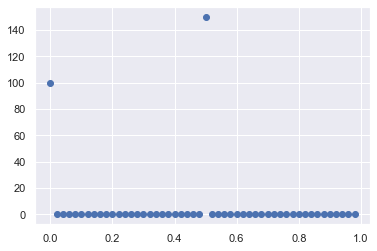

In [4]:
phi = np.zeros(N, dtype=np.uint32)
# condiciones iniciales
phi[0] = 100
phi[N//2] = 150
plt.scatter(x, phi)

In [5]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, L))
ax.set_ylim((0, max(phi)))
ax.set_ylim(auto=True, ymin=0, ymax=max(phi))

line, = ax.plot([], [], 'o', lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    global phi
    phi = actualiza_phi(phi)
    line.set_data(x, phi)
    return (line,)

### call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=40, blit=True)

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
rc
tohtml = anim.to_jshtml()
plt.clf()

HTML(tohtml)

<Figure size 432x288 with 0 Axes>